In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# File paths
HIV_FILE_PATH = 'HIV data 2000-2023.csv'
POVERTY_FILE_PATH = 'multidimensional_poverty.xlsx'

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# --- 1. Load and Clean HIV Data ---
print("Loading HIV data...")
try:
    df_hiv = pd.read_csv(HIV_FILE_PATH, encoding='latin-1')
    print(f"HIV data loaded successfully: {df_hiv.shape} rows.")
    
    # Cleaning column names
    df_hiv.columns = df_hiv.columns.str.strip()
    
    # Filtering for relevant indicator
    indicator_code = 'HIV_0000000001'  # People living with HIV
    df_hiv = df_hiv[df_hiv['IndicatorCode'] == indicator_code].copy()
    print(f"Filtered to HIV indicator data: {df_hiv.shape} rows.")
    
    # Extracting numeric value from 'Value' column
    df_hiv['Value'] = df_hiv['Value'].astype(str).str.extract(r'^([^\[]+)')
    df_hiv['Value'] = df_hiv['Value'].str.replace(' ', '').str.replace(',', '')
    df_hiv['Value'] = pd.to_numeric(df_hiv['Value'], errors='coerce')
    
    # Renaming columns for clarity
    df_hiv = df_hiv.rename(columns={
        'SpatialDimValueCode': 'CountryCode',
        'Period': 'Year',
        'ParentLocationCode': 'RegionCode',
        'Value': 'HIV_Cases'
    })
    
    # Drop rows with missing values in key columns
    df_hiv.dropna(subset=['HIV_Cases', 'Year', 'CountryCode', 'RegionCode'], inplace=True)
    df_hiv['Year'] = df_hiv['Year'].astype(int)
    
    print(f"Cleaned HIV data: {df_hiv.shape} rows, {df_hiv['CountryCode'].nunique()} countries")
    print(f"Year range: {df_hiv['Year'].min()}-{df_hiv['Year'].max()}")
    
except Exception as e:
    print(f"Error loading HIV data: {e}")
    raise

# --- 2. Load and Clean Poverty Data ---
print("\nLoading Poverty data...")
try:
    # Read with header on second row
    df_poverty = pd.read_excel(POVERTY_FILE_PATH, header=1)
    
    # The first row contains the actual column names for the deprivation columns
    deprivation_cols = df_poverty.iloc[0]
    
    # Create a mapping for renaming columns
    rename_map = {}
    for i, col in enumerate(df_poverty.columns):
        if i >= 9 and i <= 14:  # Deprivation rate columns
            new_name = str(deprivation_cols[col]).replace(' (%)', '')
            rename_map[col] = new_name
    
    # Add main poverty measure
    if 'Multidimensional poverty headcount ratio (%)' in df_poverty.columns:
        rename_map['Multidimensional poverty headcount ratio (%)'] = 'MPI_Headcount'
    
    # Rename columns
    df_poverty.rename(columns=rename_map, inplace=True)
    
    # Also rename key columns
    df_poverty.rename(columns={'Country code': 'CountryCode', 'Reporting year': 'Year'}, inplace=True)
    
    # Drop the first row (which contained the column names)
    df_poverty = df_poverty.iloc[1:].reset_index(drop=True)
    
    # Convert deprivation columns to numeric
    numeric_cols = ['Year', 'Monetary', 'Educational attainment', 'Educational enrollment', 
                   'Electricity', 'Sanitation', 'Drinking water', 'MPI_Headcount']
    
    for col in numeric_cols:
        if col in df_poverty.columns:
            df_poverty[col] = pd.to_numeric(df_poverty[col].astype(str).str.replace('-', '0').str.replace('%', ''), 
                                          errors='coerce')
    
    df_poverty['Year'] = df_poverty['Year'].astype(int)
    print(f"Cleaned poverty data: {df_poverty.shape} rows, {df_poverty['CountryCode'].nunique()} countries")
    print(f"Year range: {df_poverty['Year'].min()}-{df_poverty['Year'].max()}")
    
except Exception as e:
    print(f"Error loading poverty data: {e}")
    raise

Loading HIV data...
HIV data loaded successfully: (1552, 11) rows.
Filtered to HIV indicator data: (1552, 11) rows.
Cleaned HIV data: (1084, 11) rows, 144 countries
Year range: 2000-2023

Loading Poverty data...
Cleaned poverty data: (110, 16) rows, 110 countries
Year range: 2009-2022



--- Task 1: Global Top 75% Burden Analysis ---
Top 15 countries contribute to 75% of global HIV burden:
1. South Africa (ZAF)
2. Mozambique (MOZ)
3. Nigeria (NGA)
4. Kenya (KEN)
5. United Republic of Tanzania (TZA)
6. Zimbabwe (ZWE)
7. Uganda (UGA)
8. Zambia (ZMB)
9. Malawi (MWI)
10. Brazil (BRA)
...and 5 more countries


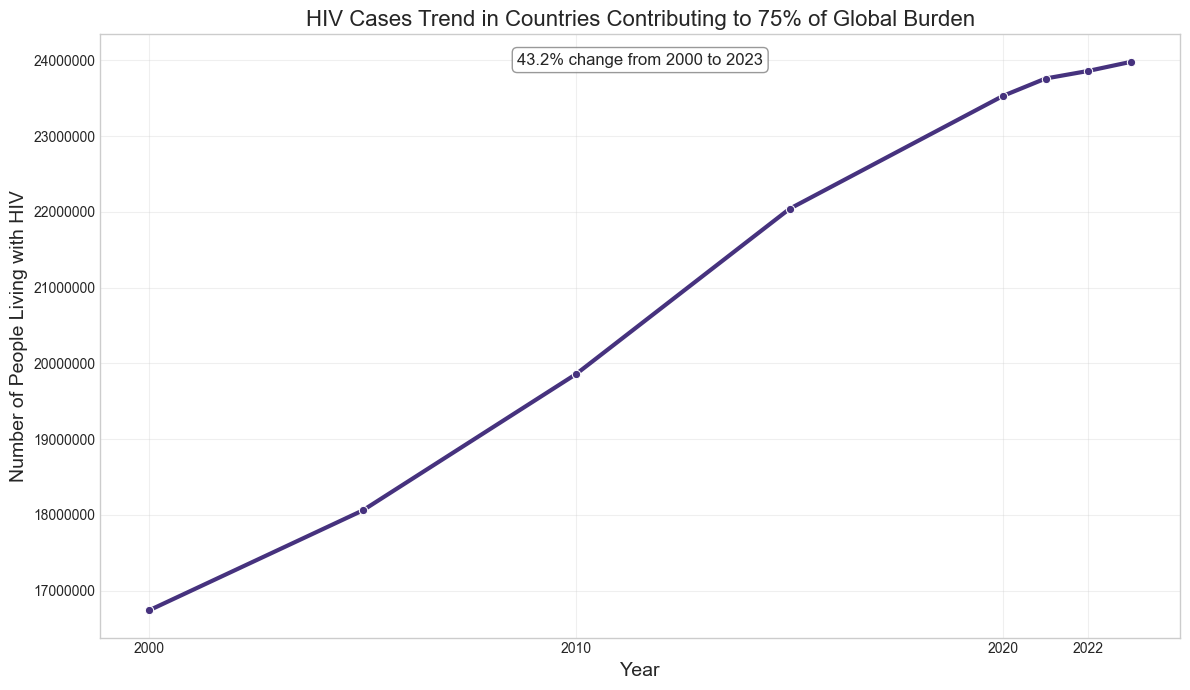


--- Task 2: Regional Top 75% Burden Analysis ---
WHO Regions in the data:
- AFR: Africa
- AMR: Americas
- EMR: Eastern Mediterranean
- EUR: Europe
- SEAR: South-East Asia
- WPR: Western Pacific

Analyzing region: Africa (AFR)
Top 9 countries contribute to 75% of Africa burden:
1. South Africa (ZAF): 28.2% of regional burden
2. Mozambique (MOZ): 8.3% of regional burden
3. Nigeria (NGA): 8.2% of regional burden
4. Kenya (KEN): 6.6% of regional burden
5. United Republic of Tanzania (TZA): 6.4% of regional burden
...and 4 more countries

Analyzing region: Americas (AMR)
Top 7 countries contribute to 75% of Americas burden:
1. Brazil (BRA): 36.6% of regional burden
2. Mexico (MEX): 13.2% of regional burden
3. Colombia (COL): 8.6% of regional burden
4. Haiti (HTI): 6.1% of regional burden
5. Argentina (ARG): 5.2% of regional burden
...and 2 more countries

Analyzing region: Eastern Mediterranean (EMR)
Top 5 countries contribute to 75% of Eastern Mediterranean burden:
1. Pakistan (PAK): 46.2

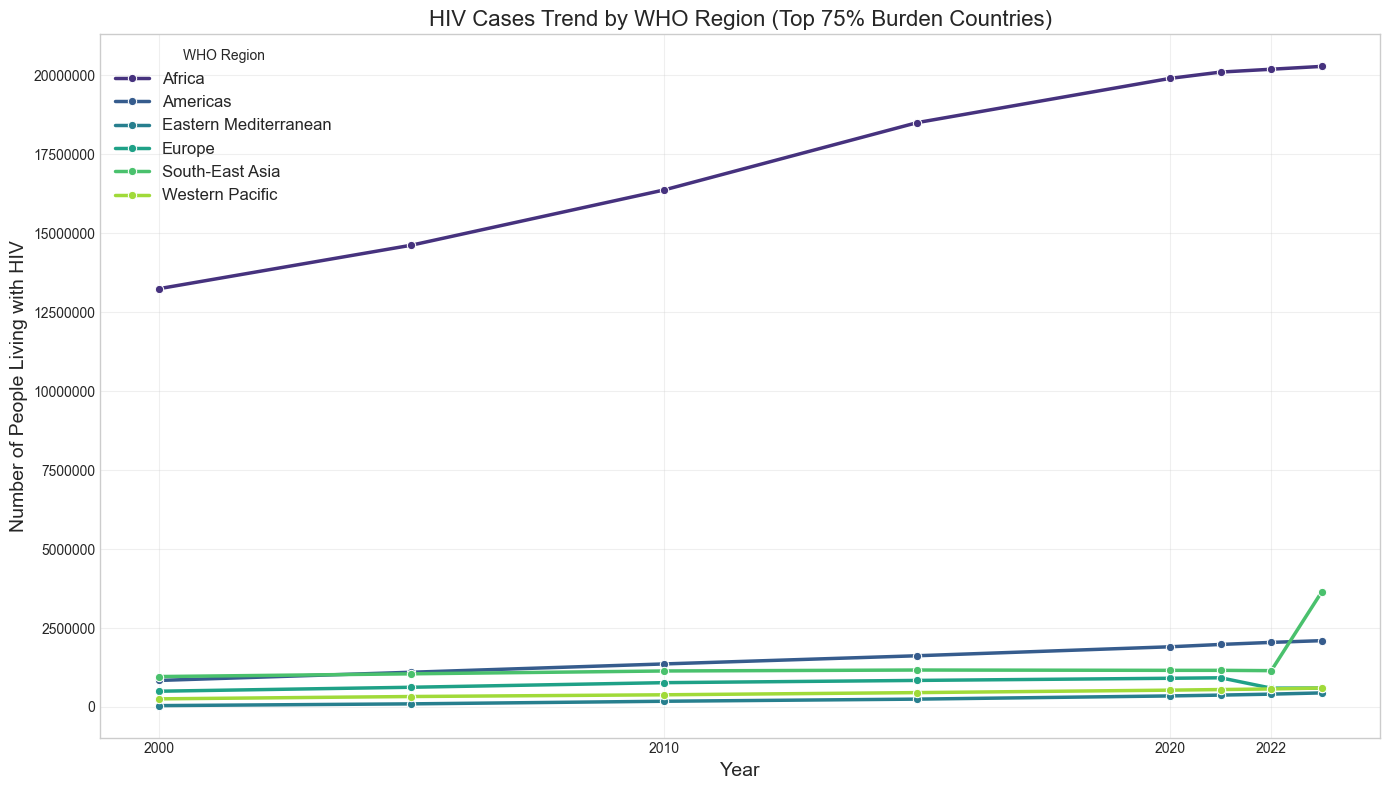


--- Task 3: HIV and Poverty Relationship Analysis ---
Merging HIV and poverty datasets...
Merged data: (39, 19) rows, 39 countries
Years covered: [2010, 2015, 2022]

Correlations between HIV Cases and Poverty Factors:
                   Factor  Correlation       P-value  Sample Size
0                Monetary     0.799411  1.043874e-09           39
6           MPI_Headcount     0.731889  1.195944e-07           39
5          Drinking water     0.730925  1.266471e-07           39
3             Electricity     0.667747  3.419476e-06           39
4              Sanitation     0.487285  1.654122e-03           39
1  Educational attainment     0.402762  1.101882e-02           39
2  Educational enrollment     0.170370  2.997604e-01           39


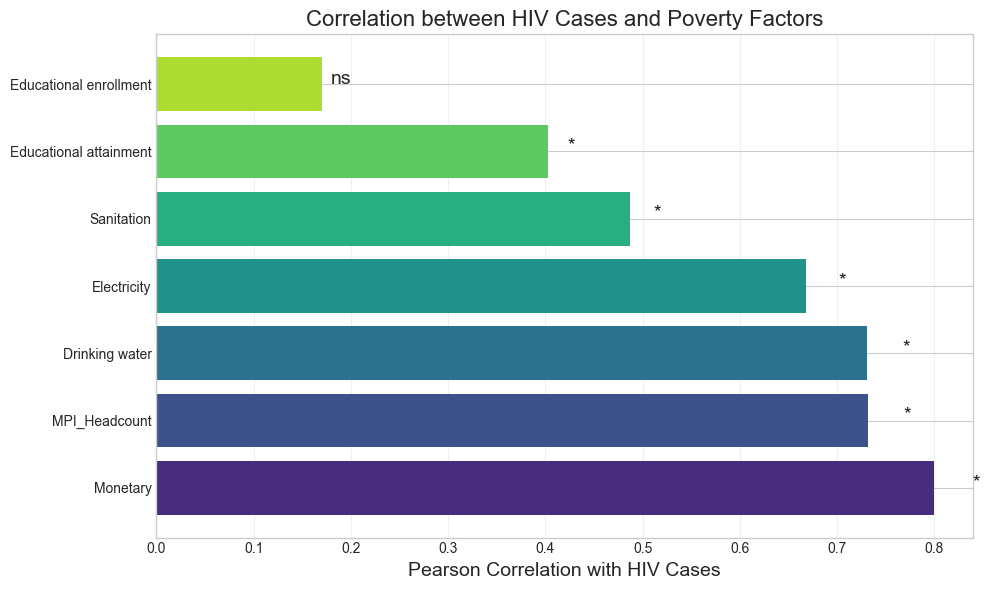


Simplified Regression Analysis:

Regressing HIV Cases on Monetary:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.837e+04   3.33e+04      0.853      0.399    -3.9e+04    9.57e+04
Monetary    1.559e+04   1925.559      8.094      0.000    1.17e+04    1.95e+04


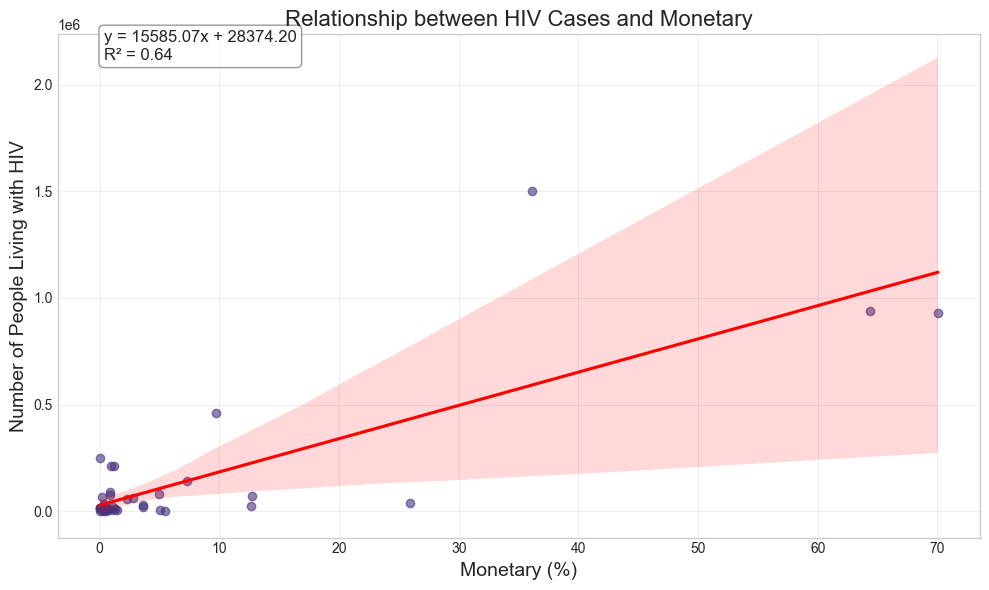


Regressing HIV Cases on Educational attainment:
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    5.64e+04   5.57e+04      1.013      0.318   -5.64e+04    1.69e+05
Educational attainment  9292.1781   3471.634      2.677      0.011    2257.980    1.63e+04


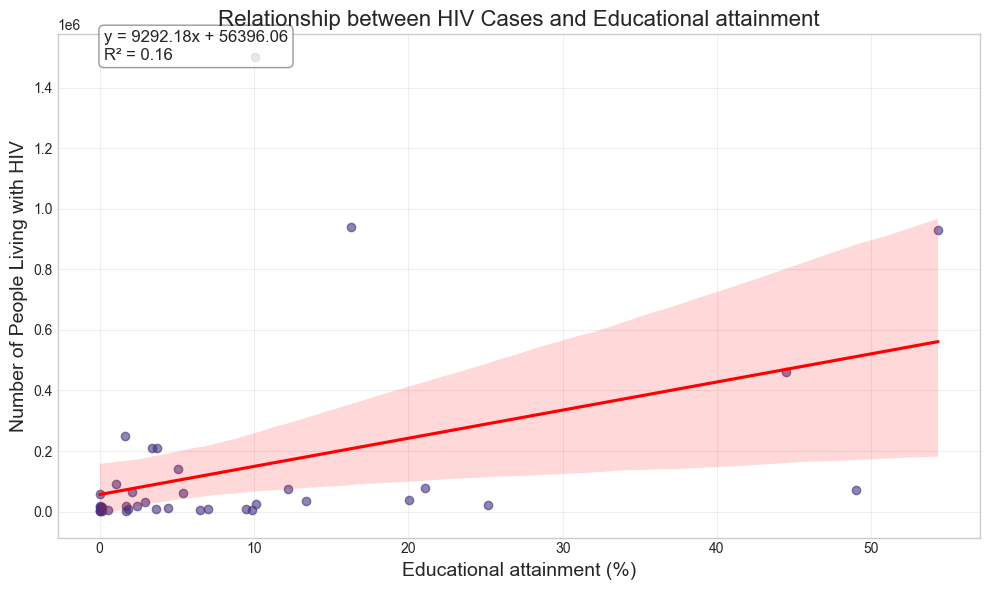


Regressing HIV Cases on Educational enrollment:
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.097e+05   5.74e+04      1.910      0.064   -6694.628    2.26e+05
Educational enrollment  5795.2186   5510.366      1.052      0.300   -5369.843     1.7e+04


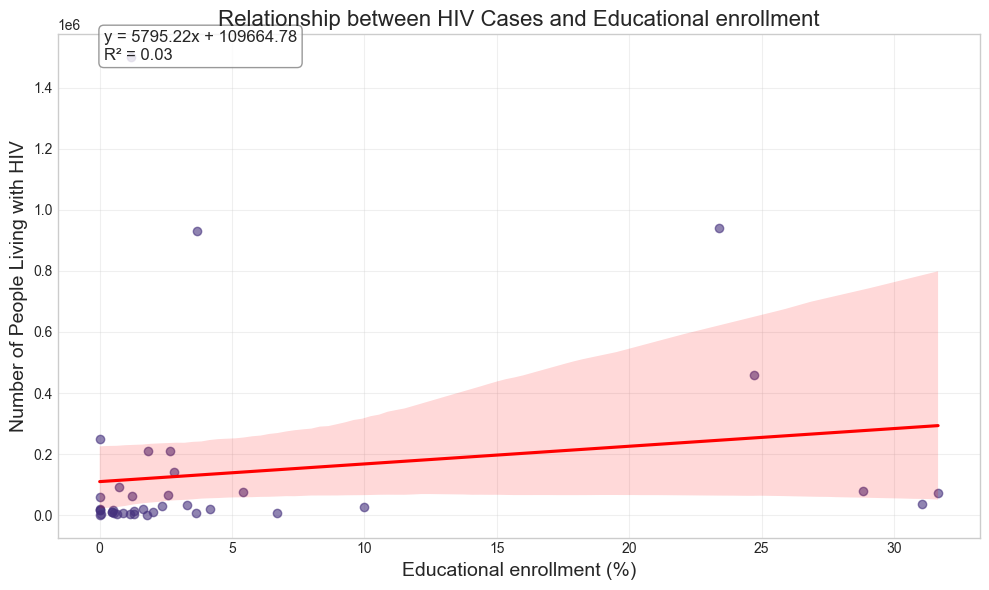


Regressing HIV Cases on Electricity:
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.548e+04   4.06e+04      1.368      0.180   -2.67e+04    1.38e+05
Electricity  1.222e+04   2239.485      5.456      0.000    7682.086    1.68e+04


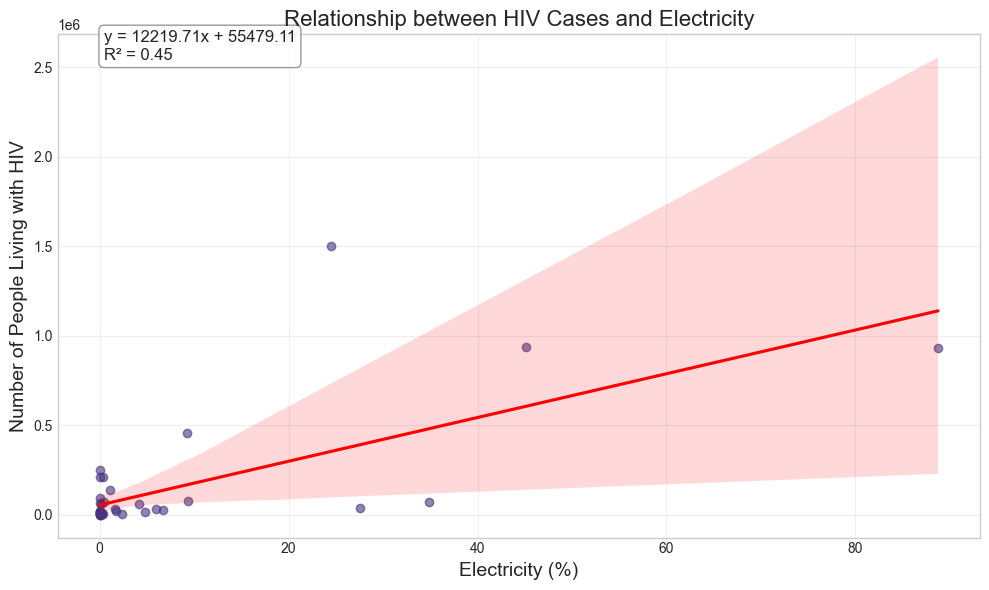


Regressing HIV Cases on Sanitation:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.382e+04    5.4e+04      0.627      0.535   -7.55e+04    1.43e+05
Sanitation  7159.8732   2109.388      3.394      0.002    2885.848    1.14e+04


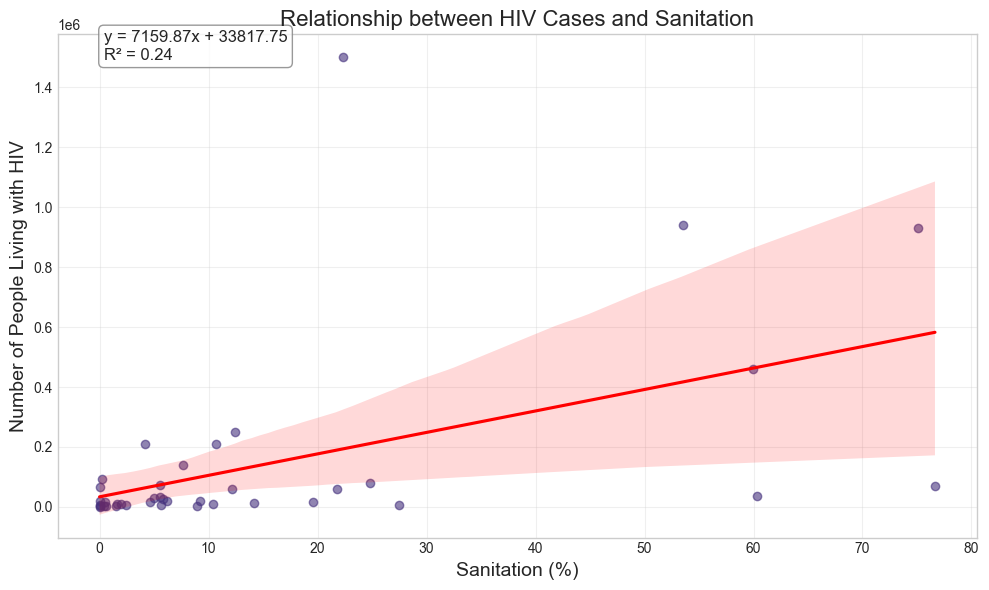


Regressing HIV Cases on Drinking water:
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.832e+04   4.21e+04     -0.435      0.666   -1.04e+05     6.7e+04
Drinking water  2.694e+04   4135.050      6.515      0.000    1.86e+04    3.53e+04


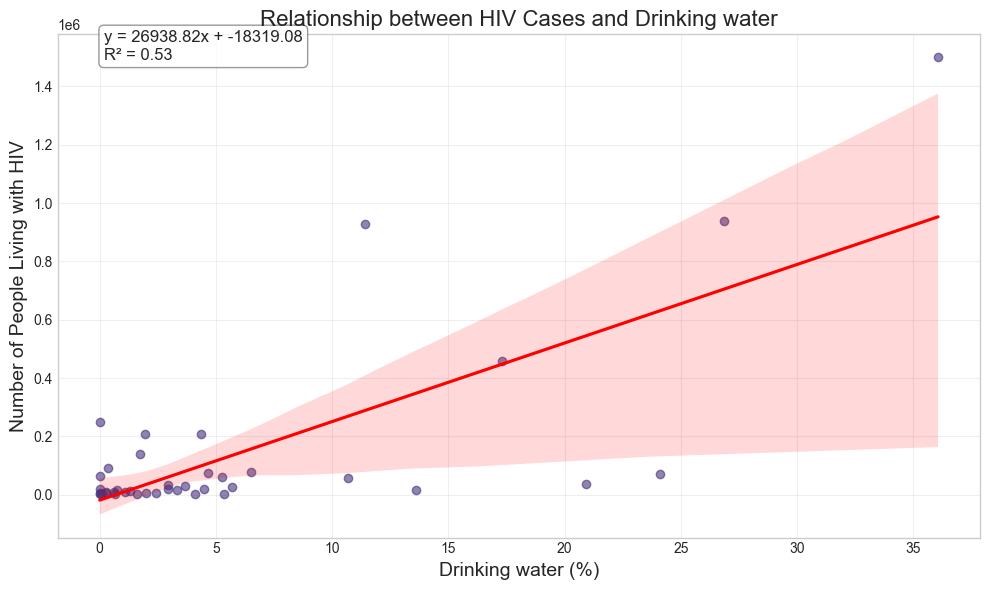


Regressing HIV Cases on MPI_Headcount:
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.766e+04   3.91e+04      0.452      0.654   -6.16e+04    9.69e+04
MPI_Headcount  1.216e+04   1861.345      6.533      0.000    8389.173    1.59e+04


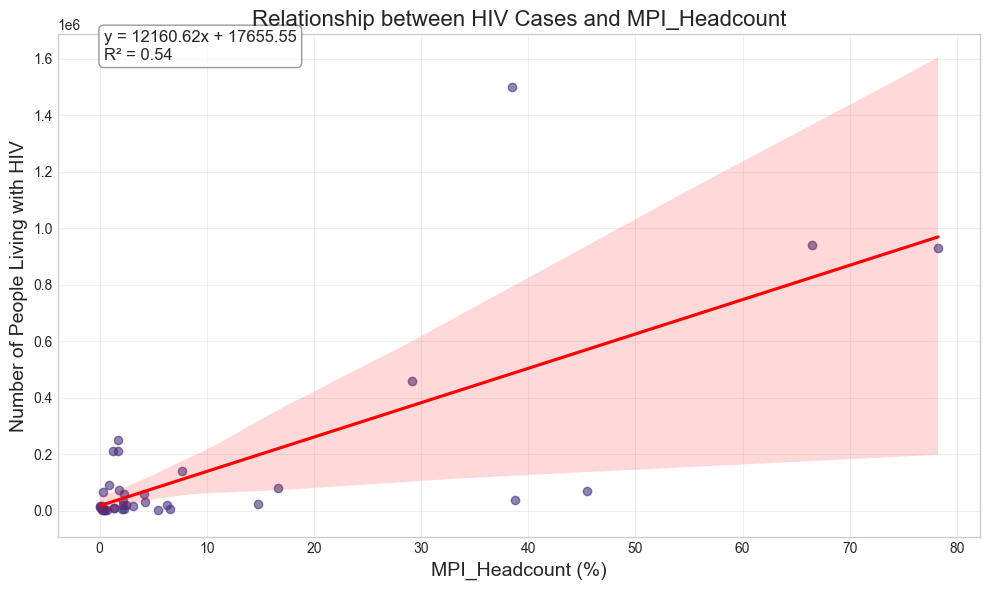


Country-level Analysis for Top HIV Burden Countries:
Found poverty data for 3 of the top 10 HIV burden countries

Summary of top HIV burden countries with poverty data:
  Country CountryCode  HIV Cases  MPI Headcount   Monetary  \
0   Kenya         KEN  1500000.0      38.490102  36.146057   
1  Zambia         ZMB   940000.0      66.506058  64.341974   
2  Malawi         MWI   930000.0      78.252000  70.060599   

   Educational attainment  Educational enrollment  Electricity  Sanitation  \
0               10.055726                1.179968    24.500306   22.312516   
1               16.267821               23.398350    45.135146   53.505135   
2               54.329389                3.686354    88.757396   75.137657   

   Drinking water  
0       36.060327  
1       26.849246  
2       11.400399  

Analysis Complete


In [ ]:
# --- 3. Global Top 75% Burden Analysis ---
print("\n--- Task 1: Global Top 75% Burden Analysis ---")

# Calculate total burden across all years by country
country_burden = df_hiv.groupby('CountryCode')['HIV_Cases'].sum().sort_values(ascending=False)
country_total = country_burden.sum()
country_cumulative = country_burden.cumsum() / country_total

# Find countries making up 75% of global burden
top_countries = country_cumulative[country_cumulative <= 0.75].index.tolist()

# Get one more country if needed to pass 75%
if len(top_countries) > 0 and country_cumulative.loc[top_countries[-1]] < 0.75:
    next_idx = list(country_cumulative.index).index(top_countries[-1]) + 1
    if next_idx < len(country_cumulative):
        top_countries.append(country_cumulative.index[next_idx])

# Get country names for these country codes
country_names = df_hiv[['CountryCode', 'Location']].drop_duplicates().set_index('CountryCode')
top_countries_with_names = [(code, country_names.loc[code, 'Location'] if code in country_names.index else code) 
                           for code in top_countries]

print(f"Top {len(top_countries)} countries contribute to 75% of global HIV burden:")
for i, (code, name) in enumerate(top_countries_with_names[:10]):
    print(f"{i+1}. {name} ({code})")
if len(top_countries) > 10:
    print(f"...and {len(top_countries) - 10} more countries")

# Filter data for visualization
df_top_global = df_hiv[df_hiv['CountryCode'].isin(top_countries)].copy()

# Create yearly trend
yearly_trend = df_top_global.groupby('Year')['HIV_Cases'].sum().reset_index()

# Visualization - directly display in notebook
plt.figure(figsize=(12, 7))
sns.lineplot(x='Year', y='HIV_Cases', data=yearly_trend, linewidth=3, marker='o')
plt.title('HIV Cases Trend in Countries Contributing to 75% of Global Burden', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of People Living with HIV', fontsize=14)
plt.xticks(yearly_trend['Year'].unique()[::2])  # Show every other year
plt.ticklabel_format(style='plain', axis='y')  # Don't use scientific notation
plt.grid(True, alpha=0.3)

# Add trend annotation
if len(yearly_trend) > 1:
    start_val = yearly_trend.iloc[0]['HIV_Cases']
    end_val = yearly_trend.iloc[-1]['HIV_Cases']
    percent_change = ((end_val - start_val) / start_val) * 100
    plt.annotate(f"{percent_change:.1f}% change from {yearly_trend['Year'].min()} to {yearly_trend['Year'].max()}", 
                xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()  # Display in notebook instead of saving

# --- 4. Regional Top 75% Burden Analysis ---
print("\n--- Task 2: Regional Top 75% Burden Analysis ---")

# Get region names
region_names = df_hiv[['RegionCode', 'ParentLocation']].drop_duplicates().set_index('RegionCode')
print("WHO Regions in the data:")
for code, name in region_names.iterrows():
    print(f"- {code}: {name['ParentLocation']}")

# Analyze each region separately
regional_top_countries = {}
region_trend_data = pd.DataFrame()

for region_code, region_data in df_hiv.groupby('RegionCode'):
    region_name = region_names.loc[region_code, 'ParentLocation']
    print(f"\nAnalyzing region: {region_name} ({region_code})")
    
    # Calculate country burden within this region
    region_country_burden = region_data.groupby('CountryCode')['HIV_Cases'].sum().sort_values(ascending=False)
    region_total = region_country_burden.sum()
    region_cumulative = region_country_burden.cumsum() / region_total
    
    # Find countries making up 75% of regional burden
    region_top = region_cumulative[region_cumulative <= 0.75].index.tolist()
    
    # Get one more country if needed to pass 75%
    if len(region_top) > 0 and region_cumulative.loc[region_top[-1]] < 0.75:
        next_idx = list(region_cumulative.index).index(region_top[-1]) + 1
        if next_idx < len(region_cumulative):
            region_top.append(region_cumulative.index[next_idx])
    
    regional_top_countries[region_code] = region_top
    
    # Get country names
    top_names = [(code, country_names.loc[code, 'Location'] if code in country_names.index else code) 
                 for code in region_top]
    
    print(f"Top {len(region_top)} countries contribute to 75% of {region_name} burden:")
    for i, (code, name) in enumerate(top_names[:5]):
        burden_pct = (region_country_burden[code] / region_total) * 100
        print(f"{i+1}. {name} ({code}): {burden_pct:.1f}% of regional burden")
    if len(top_names) > 5:
        print(f"...and {len(top_names) - 5} more countries")
    
    # Filtering data for visualization and create yearly trend
    region_filtered = region_data[region_data['CountryCode'].isin(region_top)].copy()
    region_yearly = region_filtered.groupby('Year')['HIV_Cases'].sum().reset_index()
    region_yearly['RegionCode'] = region_code
    region_yearly['Region'] = region_name
    
    # Add to combined dataset
    region_trend_data = pd.concat([region_trend_data, region_yearly])

# Visualization of regional trends 
plt.figure(figsize=(14, 8))
sns.lineplot(x='Year', y='HIV_Cases', hue='Region', data=region_trend_data, linewidth=2.5, marker='o')
plt.title('HIV Cases Trend by WHO Region (Top 75% Burden Countries)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of People Living with HIV', fontsize=14)
plt.xticks(region_trend_data['Year'].unique()[::2])  # Show every other year
plt.ticklabel_format(style='plain', axis='y')  # Don't use scientific notation
plt.grid(True, alpha=0.3)
plt.legend(title='WHO Region', fontsize=12)

plt.tight_layout()
plt.show()  # Display in notebook instead of saving

# --- 5. HIV and Poverty Relationship Analysis ---
print("\n--- Task 3: HIV and Poverty Relationship Analysis ---")

# Merge datasets
print("Merging HIV and poverty datasets...")
df_merged = pd.merge(
    df_hiv[['CountryCode', 'Year', 'HIV_Cases', 'Location', 'RegionCode']], 
    df_poverty,
    on=['CountryCode', 'Year'],
    how='inner'
)

print(f"Merged data: {df_merged.shape} rows, {df_merged['CountryCode'].nunique()} countries")
print(f"Years covered: {sorted(df_merged['Year'].unique())}")

# Check if we have sufficient data for analysis
if df_merged.shape[0] < 20:
    print("\nWARNING: Limited data available for regression analysis.")
    print("Proceeding with descriptive analysis instead.")

# --- Correlation Analysis ---
# Get deprivation columns that are present in the data
deprivation_cols = ['Monetary', 'Educational attainment', 'Educational enrollment',
                   'Electricity', 'Sanitation', 'Drinking water', 'MPI_Headcount']
available_cols = [col for col in deprivation_cols if col in df_merged.columns]

# Calculate correlations with HIV cases
correlations = []
for col in available_cols:
    if df_merged[col].notna().sum() > 5:  # Only if we have at least 5 data points
        corr, p_value = stats.pearsonr(df_merged['HIV_Cases'], df_merged[col])
        correlations.append({
            'Factor': col,
            'Correlation': corr,
            'P-value': p_value,
            'Sample Size': df_merged[col].notna().sum()
        })

# Display correlation results
if correlations:
    print("\nCorrelations between HIV Cases and Poverty Factors:")
    corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
    print(corr_df)
    
    # Visualization of correlations - directly display in notebook
    plt.figure(figsize=(10, 6))
    bars = plt.barh(corr_df['Factor'], corr_df['Correlation'], color=sns.color_palette("viridis", len(corr_df)))
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Pearson Correlation with HIV Cases', fontsize=14)
    plt.title('Correlation between HIV Cases and Poverty Factors', fontsize=16)
    
    # Add significance markers
    for i, p in enumerate(corr_df['P-value']):
        marker = '*' if p < 0.05 else 'ns'
        plt.text(corr_df['Correlation'].iloc[i] * 1.05, i, marker, fontsize=14)
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()  # Display in notebook instead of saving

# --- Simplified Regression Analysis ---
# If we have enough data points for at least one factor, run a simple regression
print("\nSimplified Regression Analysis:")
for col in available_cols:
    # Filter to rows with data for this column
    temp_df = df_merged[['HIV_Cases', col]].dropna()
    
    if len(temp_df) >= 10:  # Only if we have at least 10 data points
        print(f"\nRegressing HIV Cases on {col}:")
        X = sm.add_constant(temp_df[col])
        model = sm.OLS(temp_df['HIV_Cases'], X).fit()
        print(model.summary().tables[1])  # Print the coefficients table
        
        # Create scatter plot with regression line - directly display in notebook
        plt.figure(figsize=(10, 6))
        sns.regplot(x=col, y='HIV_Cases', data=temp_df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
        plt.title(f'Relationship between HIV Cases and {col}', fontsize=16)
        plt.xlabel(f'{col} (%)', fontsize=14)
        plt.ylabel('Number of People Living with HIV', fontsize=14)
        plt.grid(True, alpha=0.3)
        
        # Add regression equation
        slope = model.params[1]
        intercept = model.params[0]
        r2 = model.rsquared
        plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}', 
                    xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.tight_layout()
        plt.show()  # Display in notebook instead of saving
    else:
        print(f"Insufficient data for {col} regression (n={len(temp_df)})")

# --- Country-level Analysis for top HIV burden countries ---
print("\nCountry-level Analysis for Top HIV Burden Countries:")

# Get top 10 countries by total HIV burden
top10_countries = country_burden.nlargest(10).index.tolist()
top10_with_poverty = [c for c in top10_countries if c in df_merged['CountryCode'].unique()]

if top10_with_poverty:
    print(f"Found poverty data for {len(top10_with_poverty)} of the top 10 HIV burden countries")
    
    # Create a summary table
    summary_rows = []
    for country in top10_with_poverty:
        country_data = df_merged[df_merged['CountryCode'] == country].iloc[0]
        row = {
            'Country': country_data['Location'],
            'CountryCode': country,
            'HIV Cases': country_data['HIV_Cases'],
            'MPI Headcount': country_data.get('MPI_Headcount', np.nan)
        }
        # Add available deprivation factors
        for col in available_cols:
            if col != 'MPI_Headcount':
                row[col] = country_data.get(col, np.nan)
        summary_rows.append(row)
    
    summary_df = pd.DataFrame(summary_rows)
    print("\nSummary of top HIV burden countries with poverty data:")
    print(summary_df)
else:
    print("No poverty data available for top HIV burden countries")

print("\nAnalysis Complete")